In [25]:
import json
import os
from PIL import Image, ImageDraw
import numpy as np
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
root = "/home/eirikmv/cv_project2/raw_data"

labels = os.path.join(root, "JSON", "kaggle_data_1.json")
images = os.path.join(root, "background_images")

with open(labels, "rb") as file:
    labels = json.load(file)

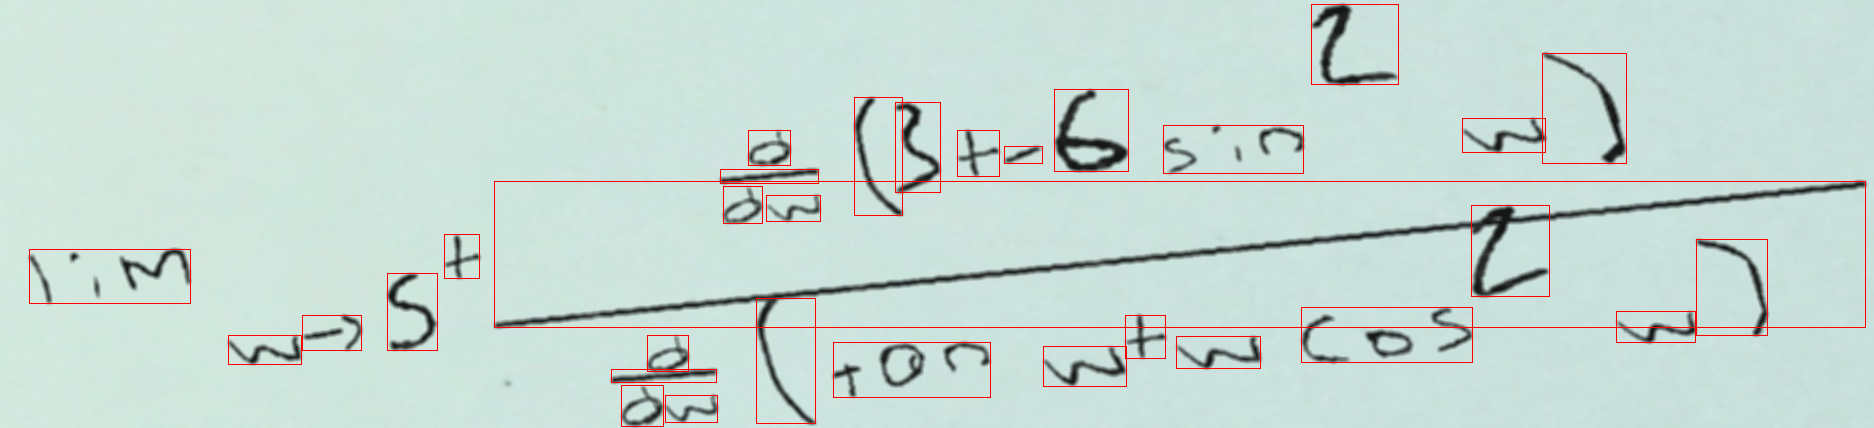

In [3]:
rndimg = np.random.randint(0, 10000)

_img = labels[rndimg]["filename"]

for file in os.listdir(images):

    if file == _img:
        img = Image.open(os.path.join(images, file))
        draw = ImageDraw.Draw(img)

        xmin = labels[rndimg]["image_data"]["xmins_raw"]
        xmax = labels[rndimg]["image_data"]["xmaxs_raw"]
        ymin = labels[rndimg]["image_data"]["ymins_raw"]
        ymax = labels[rndimg]["image_data"]["ymaxs_raw"]

        # Iterate over each bounding box coordinate and draw the rectangle
        for x_min, x_max, y_min, y_max in zip(xmin, xmax, ymin, ymax):
            # Draw bounding box rectangle
            draw.rectangle([x_min, y_min, x_max, y_max], outline="red")

        display(img)

In [50]:
project_root = f"/home/{os.environ['USER']}/cv_project2"
if not os.path.exists(project_root):
    os.mkdir(project_root)

dataset_root = os.path.join(project_root, "dataset")
if not os.path.exists(dataset_root):
    os.mkdir(dataset_root)

train_dir = os.path.join(dataset_root, "train")
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

val_dir = os.path.join(dataset_root, "valid")
if not os.path.exists(val_dir):
    os.mkdir(val_dir)

train_x_dir = os.path.join(train_dir, "images")
if not os.path.exists(train_x_dir):
    os.mkdir(train_x_dir)

val_x_dir = os.path.join(val_dir, "images")
if not os.path.exists(val_x_dir):
    os.mkdir(val_x_dir)

train_y_dir = os.path.join(train_dir, "labels")
if not os.path.exists(train_y_dir):
    os.mkdir(train_y_dir)

val_y_dir = os.path.join(val_dir, "labels")
if not os.path.exists(val_y_dir):
    os.mkdir(val_y_dir)

In [ ]:
keep = ["+", "-", "=", "x", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "y", "z", "\\left(", "\\right)", "\\cos", "\\pi", "\\sin", "\\sqrt", "\\tan", "/"]

pickle.dump(keep, open("keep.pkl", "wb"))

In [45]:
# labels[0]["image_data"]["width"]
# labels[0]["image_data"]["height"]
# labels[0]["image_data"]["visible_latex_chars"]
# labels[0]["image_data"]["xmins_raw"]
# labels[0]["image_data"]["xmaxs_raw"]
# labels[0]["image_data"]["ymins_raw"]
# labels[0]["image_data"]["ymaxs_raw"]) 


def draw_and_display(img, xmin, xmax, ymin, ymax):
    draw = ImageDraw.Draw(img)

    for x_min, x_max, y_min, y_max in zip(xmin, xmax, ymin, ymax):
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red")

    display(img)


def convert_to_yolo_bbox(image_width, image_height, xmin, xmax, ymin, ymax):
    
    bbox_width = xmax - xmin
    bbox_height = ymax - ymin
    center_x = xmin + bbox_width / 2
    center_y = ymin + bbox_height / 2

    center_x /= image_width
    center_y /= image_height
    bbox_width /= image_width
    bbox_height /= image_height

    return center_x, center_y, bbox_width, bbox_height


def get_img_info(all_img_data, filename):

    with open("keep.pkl", "rb") as file:
        keep = pickle.load(file)

    for j, imginfo in enumerate(all_img_data):

        if imginfo["filename"] == filename:
            
            img = imginfo["image_data"]
            width = img["width"]
            height = img["height"]

            keep_classes = [i for i,lab in enumerate(imginfo["image_data"]["visible_latex_chars"]) if lab in keep]
            
            img_classes = [imginfo["image_data"]["visible_latex_chars"][i] for i in keep_classes]
            
            xmin = [imginfo["image_data"]["xmins_raw"][i] for i in keep_classes]
            xmax = [imginfo["image_data"]["xmaxs_raw"][i] for i in keep_classes]
            ymin = [imginfo["image_data"]["ymins_raw"][i] for i in keep_classes]
            ymax = [imginfo["image_data"]["ymaxs_raw"][i] for i in keep_classes]
            
            return [img_classes, width, height, xmin, xmax, ymin, ymax]
    
    assert False, f"Image {filename} not found"
        

In [43]:
train, test = train_test_split(os.listdir(images), test_size=0.2, random_state=42)

In [51]:
def make_data(files : list, x_path : str, y_path : str, settype : str):

    for i, filename in enumerate(tqdm(files)):

        center_x, center_y, bbox_width, bbox_height = [], [], [], []

        img = Image.open(os.path.join(images, filename))
        img_data = get_img_info(labels, filename)
        
        if img_data[0] == []:
            continue
        
        for xmin, xmax, ymin, ymax in zip(img_data[3], img_data[4], img_data[5], img_data[6]):
            
            c_x, c_y, b_w, b_h = convert_to_yolo_bbox(img_data[1], img_data[2], xmin, xmax, ymin, ymax)
            
            center_x.append(c_x)
            center_y.append(c_y)
            bbox_width.append(b_w)
            bbox_height.append(b_h)

        with open("keep.pkl", "rb") as f:
            keep = pickle.load(f)

        with open(os.path.join(y_path, f"{settype}_{i}.txt"), "w") as f:
            for c, (c_x, c_y, b_w, b_h) in enumerate(zip(center_x, center_y, bbox_width, bbox_height)):                
                
                is_class = keep.index(img_data[0][c])
                f.write(f"{is_class} {c_x} {c_y} {b_w} {b_h}\n")

        img.save(os.path.join(x_path, f"{settype}_{i}.jpg"))


make_data(train, train_x_dir, train_y_dir, "train")
make_data(test, val_x_dir, val_y_dir, "val")

100%|██████████| 2000/2000 [00:06<00:00, 303.47it/s]


In [52]:
# create yaml file
with open(os.path.join(project_root, "config.yaml"), "w") as f:
    f.write(f"train: {train_x_dir}\n")
    f.write(f"val: {val_x_dir}\n")
    f.write(f"nc: {len(keep)}\n")
    f.write(f"names: {keep}")